In [12]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy
from collections import OrderedDict
import random
import csv

In [13]:
%load_ext PWE_NB_Extension

The PWE_NB_Extension extension is already loaded. To reload it, use:
  %reload_ext PWE_NB_Extension


In [14]:
def turn_list_into_str(l):
    # small bug fix 
    if isinstance(l, (list,set,frozenset)):
        if len(l) > 1:
            l_ = [turn_list_into_str(l1) for l1 in l[1:]]
            return "{}({})".format(l[0], ",".join(l_))
        elif len(l) == 1:
            return "{}".format(l[0])
        else:
            return ""
    else:
        return l


In [15]:
def sql2clingo(sqlCommand,originalSchema,colour='black'):
    sql = sqlCommand.replace('"','')
    sqlList = sql.split(' ') 
    #print(sqlList)
    schemaList = originalSchema.split(',')
    #print(schemaList)
    clingoString = 0
    #print(sqlList[0])
    if sqlList[0] == 'UPDATE':
        sql = sql.replace(' = ','=')
        sql = sql.replace(' > ','>')
        sql = sql.replace(' < ','<')
        sql = sql.replace(' >= ','>=')
        sql = sql.replace(' <= ','<=')
        sql = sql.replace(',','')
        sqlList = sql.split(' ') 
        setLoc = sqlList.index('SET')
        whereLoc = sqlList.index('WHERE')
        setCommands = sqlList[setLoc+1:whereLoc]
        setCommands = [x.upper() for x in setCommands]
        whereCommands = sqlList[whereLoc+1:]
        whereCommands = [x.upper() for x in whereCommands if x != 'AND']
        whereCommandsString = '-'.join(whereCommands)
        whereCommandsComma = ','.join(whereCommands)
        setLocs = [x[:x.index('=')] for x in setCommands]
        setValues = [x[x.index('=')+1:] for x in setCommands]
        setVals = []
        startSetVals = []
        for x in (schemaList):
            if x in setLocs:
                loc = setLocs.index(x)
                setVals.append(setValues[loc])
                startSetVals.append('_')
            else:
                setVals.append(x)
                startSetVals.append(x)
        setValsString = ','.join(setVals)
        #clingoString = 'data('+setValsString+',black,"'+whereCommandsString+'",'+originalSchema+') :- data('+originalSchema+',_,_,_,_,_,_,_,_,_),'+whereCommandsComma+'.'
        clingoString = 'e(data('+setValsString+',prov(P,"'+whereCommandsString+'")),data('+originalSchema+',P),trans('+colour+',"'+whereCommandsString+'")) :- data('+originalSchema+',P),'+whereCommandsComma+'.'
    if sqlList[0] == 'INSERT':
        locator = 'VALUES('
        loc1 = sql.index(locator)
        loc2 = sql[loc1:].index(')')+loc1
        datavalues = sql[loc1+len(locator):loc2]
        datavaluesDash = datavalues.replace(',','-')
        clingoString = 'data('+datavalues+',"INSERT'+datavaluesDash+'").'
    
    return clingoString

In [16]:
def makeOriginal(dataValues,colour='black'):
    clingoStart = []
    for x in dataValues:
        clingoStart.append('data('+','.join(x)+',"").')
    return clingoStart

In [135]:
def addConversion(dataValues):
    variables = []
    spaces = ['_']*len(dataValues)
    #underscores = ','.join(spaces)
        
    variables = [chr(65+x) for x in range(len(dataValues))]
    clingoHead = 'data('+','.join(variables)+',P) :-'
    clingoBody = 'e(data('+','.join(variables)+',P),data('+','.join(spaces)+',P),trans(_,_)).'
    
    
    return clingoHead+clingoBody

In [18]:
def smallConvert(string):
    b = string.replace('data(','')
    b = b[:-1]
    c = b.replace('),',')\n')
    return c

In [31]:
def cleanCSVFile(csv,outCSV):
    with open(csv,'r') as f:
        data = f.read()
    dataNew = data.replace('(','')
    dataNew2 = dataNew.replace(')','')
    with open(outCSV,'w') as f:
        f.write(dataNew2)
    print(dataNew2)

In [62]:
originalSchema = 'id,a0,a1,a2,a3,a4,a5'.upper()

In [32]:
testDataNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows1000_Nqueries10.csv']
testQueryNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows100_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows1000_Nqueries10.csv']

In [113]:
testDataNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries50.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries50.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows500_Nqueries50.csv']
testQueryNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows50_Nqueries50.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows100_Nqueries50.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows500_Nqueries50.csv']

In [114]:
testData = testDataNames[2]
testQueries = testQueryNames[2]

In [115]:
cleanCSVFile(testData,'testData.csv')
testData = 'testData.csv'

0, 13, 85, 77, 27, 52, 48
1, 65, 79, 11, 5, 85, 46
2, 76, 1, 46, 73, 26, 95
3, 91, 4, 4, 56, 95, 41
4, 21, 43, 4, 24, 46, 52
5, 23, 24, 23, 48, 32, 7
6, 84, 56, 65, 21, 100, 87
7, 12, 34, 73, 72, 94, 45
8, 83, 68, 32, 60, 89, 86
9, 51, 59, 5, 26, 81, 44
10, 17, 55, 71, 69, 40, 47
11, 51, 78, 53, 41, 51, 7
12, 4, 71, 99, 61, 42, 21
13, 50, 99, 78, 55, 87, 27
14, 51, 96, 59, 47, 30, 57
15, 96, 1, 79, 83, 89, 76
16, 81, 52, 57, 44, 9, 88
17, 57, 20, 51, 50, 38, 38
18, 54, 63, 62, 47, 6, 27
19, 17, 59, 87, 81, 81, 83
20, 25, 85, 68, 11, 5, 6
21, 76, 25, 12, 64, 37, 11
22, 16, 53, 18, 29, 73, 48
23, 32, 48, 4, 40, 44, 23
24, 10, 90, 52, 23, 62, 83
25, 2, 2, 16, 73, 19, 72
26, 68, 55, 23, 98, 81, 54
27, 22, 65, 41, 59, 35, 65
28, 5, 30, 97, 88, 33, 87
29, 31, 94, 75, 43, 28, 5
30, 88, 4, 83, 97, 59, 21
31, 87, 98, 71, 52, 40, 38
32, 20, 68, 44, 22, 14, 68
33, 29, 50, 34, 88, 91, 6
34, 20, 33, 99, 79, 36, 25
35, 68, 84, 94, 36, 89, 70
36, 48, 99, 25, 74, 12, 21
37, 92, 22, 77, 61, 85, 40
38, 

In [136]:
dataSet = []
with open(testData,'r') as csvfile:
    reader = csv.reader(csvfile,delimiter=' ',quotechar='|')
    for row in reader:
        dataSet.append([' '.join(row)])

originalSetup = makeOriginal(dataSet)

with open(testQueries,'r') as f:
    data = f.read()
#print(data)    
queries = data.split('\n')
#print(queries)

commands = []
for x in queries:
    clingoString = sql2clingo(x,originalSchema)
    if clingoString != 0:
        commands.append(clingoString)
        
edgeNodeConv = addConversion(originalSchema.split(','))

clingo_rules = ['% schema data('+originalSchema+',prov)','% schema e(DATAEND,DATASTART,TRANS)']
clingo_rules.extend(originalSetup)
clingo_rules.extend(commands)
clingo_rules.extend([edgeNodeConv])



In [137]:
ASPRules('\n'.join(commands))

'e(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(500,44,50,23,23,22,46,"INSERT500-44-50-23-23-22-46").\ndata(501,2,84,56,64,18,100,"INSERT501-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(502,4,71,99,59,39,17,"INSERT502-4-71-99-59-39-17").\ne(data(ID,A0,77,54,A3,A4,A5,prov(P,"A1>=78-A1<88-A4>=21-A4<31")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=78-A1<88-A4>=21-A4<31")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=78,A1<88,A4>=21,A4<31.\ne(data(ID,A0,58,46,A3,A4,A5,prov(P,"A1>=24-A1<34-A4>=49-A4<59")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=24-A1<34-A4>=49-A4<59")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=24,A1<34,A4>=49,A4<59.\ne(data(ID,A0,79,82,A3,A4,A5,prov(P,"A1=89-A5=74")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=89-A5=74")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=89,A5=74.\ne(data(ID,A0,56,43,A3,A4,A5,prov(P,"A1>=5-A1<15-A4>=79-A4<89")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=5-A1<15-A4>=79-A4<89")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=5,A1<15,A4>=79,A4<89.\ne(data(ID,A0,50,48,A3,A4,A5,prov(P,"A1=36-A5=34")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=36-A5=34")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=36,A5=34.\ne(data(ID,A0,61,46,A3,A4,A5,prov(P,"A1>=2-A1<12-A4>=20-A4<30")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=2-A1<12-A4>=20-A4<30")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=2,A1<12,A4>=20,A4<30.\ndata(503,59,86,80,80,82,25,"INSERT503-59-86-80-80-82-25").\ne(data(ID,A0,8,1,A3,A4,A5,prov(P,"A1>=1-A1<11-A4>=68-A4<78")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=1-A1<11-A4>=68-A4<78")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=1,A1<11,A4>=68,A4<78.\ndata(504,11,63,34,7,16,53,"INSERT504-11-63-34-7-16-53").\ndata(505,27,71,45,32,47,2,"INSERT505-27-71-45-32-47-2").\ne(data(ID,A0,18,10,A3,A4,A5,prov(P,"A1=90-A5=51")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=90-A5=51")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=90,A5=51.\ndata(506,61,82,2,1,14,72,"INSERT506-61-82-2-1-14-72").\ndata(507,71,68,55,22,98,80,"INSERT507-71-68-55-22-98-80").\ne(data(ID,A0,65,39,A3,A4,A5,prov(P,"A1=58-A5=32")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=58-A5=32")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=58,A5=32.\ne(data(ID,A0,30,97,A3,A4,A5,prov(P,"A1=88-A5=30")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=88-A5=30")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=88,A5=30.\ne(data(ID,A0,94,75,A3,A4,A5,prov(P,"A1=42-A5=25")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=42-A5=25")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=42,A5=25.\ndata(508,88,3,82,97,57,17,"INSERT508-88-3-82-97-57-17").\ne(data(ID,A0,71,51,A3,A4,A5,prov(P,"A1>=34-A1<44-A4>=31-A4<41")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=34-A1<44-A4>=31-A4<41")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=34,A1<44,A4>=31,A4<41.\ndata(509,68,43,19,10,67,29,"INSERT509-68-43-19-10-67-29").\ne(data(ID,A0,88,90,A3,A4,A5,prov(P,"A1=1-A5=20")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(b

In [138]:
ASPRules('\n'.join(originalSetup))

'data(0, 13, 85, 77, 27, 52, 48,"").\ndata(1, 65, 79, 11, 5, 85, 46,"").\ndata(2, 76, 1, 46, 73, 26, 95,"").\ndata(3, 91, 4, 4, 56, 95, 41,"").\ndata(4, 21, 43, 4, 24, 46, 52,"").\ndata(5, 23, 24, 23, 48, 32, 7,"").\ndata(6, 84, 56, 65, 21, 100, 87,"").\ndata(7, 12, 34, 73, 72, 94, 45,"").\ndata(8, 83, 68, 32, 60, 89, 86,"").\ndata(9, 51, 59, 5, 26, 81, 44,"").\ndata(10, 17, 55, 71, 69, 40, 47,"").\ndata(11, 51, 78, 53, 41, 51, 7,"").\ndata(12, 4, 71, 99, 61, 42, 21,"").\ndata(13, 50, 99, 78, 55, 87, 27,"").\ndata(14, 51, 96, 59, 47, 30, 57,"").\ndata(15, 96, 1, 79, 83, 89, 76,"").\ndata(16, 81, 52, 57, 44, 9, 88,"").\ndata(17, 57, 20, 51, 50, 38, 38,"").\ndata(18, 54, 63, 62, 47, 6, 27,"").\ndata(19, 17, 59, 87, 81, 81, 83,"").\ndata(20, 25, 85, 68, 11, 5, 6,"").\ndata(21, 76, 25, 12, 64, 37, 11,"").\ndata(22, 16, 53, 18, 29, 73, 48,"").\ndata(23, 32, 48, 4, 40, 44, 23,"").\ndata(24, 10, 90, 52, 23, 62, 83,"").\ndata(25, 2, 2, 16, 73, 19, 72,"").\ndata(26, 68, 55, 23, 98, 81, 54,"").\ndata(27, 22, 65, 41, 59, 35, 65,"").\ndata(28, 5, 30, 97, 88, 33, 87,"").\ndata(29, 31, 94, 75, 43, 28, 5,"").\ndata(30, 88, 4, 83, 97, 59, 21,"").\ndata(31, 87, 98, 71, 52, 40, 38,"").\ndata(32, 20, 68, 44, 22, 14, 68,"").\ndata(33, 29, 50, 34, 88, 91, 6,"").\ndata(34, 20, 33, 99, 79, 36, 25,"").\ndata(35, 68, 84, 94, 36, 89, 70,"").\ndata(36, 48, 99, 25, 74, 12, 21,"").\ndata(37, 92, 22, 77, 61, 85, 40,"").\ndata(38, 34, 30, 87, 62, 96, 90,"").\ndata(39, 13, 56, 12, 6, 11, 88,"").\ndata(40, 79, 83, 35, 63, 79, 41,"").\ndata(41, 57, 23, 10, 29, 90, 59,"").\ndata(42, 93, 46, 29, 80, 84, 6,"").\ndata(43, 67, 10, 13, 89, 7, 28,"").\ndata(44, 99, 43, 13, 19, 27, 76,"").\ndata(45, 10, 92, 39, 98, 92, 33,"").\ndata(46, 25, 48, 11, 66, 7, 6,"").\ndata(47, 99, 30, 61, 47, 34, 11,"").\ndata(48, 92, 97, 98, 13, 24, 64,"").\ndata(49, 98, 55, 70, 67, 29, 56,"").\ndata(50, 31, 25, 10, 30, 99, 47,"").\ndata(51, 65, 65, 95, 41, 33, 36,"").\ndata(52, 31, 85, 90, 32, 36, 57,"").\ndata(53, 58, 60, 26, 4, 27, 11,"").\ndata(54, 55, 8, 9, 65, 32, 81,"").\ndata(55, 49, 87, 17, 52, 81, 12,"").\ndata(56, 95, 18, 78, 99, 83, 35,"").\ndata(57, 10, 52, 93, 31, 90, 18,"").\ndata(58, 91, 4, 33, 91, 81, 92,"").\ndata(59, 84, 75, 70, 20, 45, 20,"").\ndata(60, 72, 67, 27, 9, 97, 82,"").\ndata(61, 55, 55, 86, 47, 42, 37,"").\ndata(62, 26, 3, 65, 43, 59, 10,"").\ndata(63, 35, 14, 14, 28, 84, 43,"").\ndata(64, 40, 62, 25, 3, 55, 53,"").\ndata(65, 65, 44, 69, 74, 27, 52,"").\ndata(66, 48, 23, 42, 57, 91, 93,"").\ndata(67, 27, 65, 6, 10, 53, 89,"").\ndata(68, 16, 77, 89, 33, 71, 86,"").\ndata(69, 37, 71, 74, 61, 87, 91,"").\ndata(70, 96, 58, 19, 27, 25, 59,"").\ndata(71, 76, 6, 69, 73, 37, 54,"").\ndata(72, 16, 73, 6, 99, 82, 65,"").\ndata(73, 27, 92, 96, 16, 79, 85,"").\ndata(74, 66, 71, 46, 93, 98, 41,"").\ndata(75, 81, 44, 18, 34, 16, 92,"").\ndata(76, 96, 12, 61, 43, 15, 33,"").\ndata(77, 25, 75, 2, 21, 46, 7,"").\ndata(78, 63, 61, 84, 23, 31, 57,"").\ndata(79, 27, 59, 26, 69, 80, 82,"").\ndata(80, 98, 55, 50, 86, 78, 59,"").\ndata(81, 38, 29, 12, 82, 15, 76,"").\ndata(82, 55, 97, 77, 98, 17, 53,"").\ndata(83, 57, 32, 51, 37, 55, 5,"").\ndata(84, 44, 45, 32, 42, 79, 70,"").\ndata(85, 49, 65, 39, 22, 4, 31,"").\ndata(86, 60, 89, 84, 53, 99, 49,"").\ndata(87, 84, 41, 75, 99, 33, 21,"").\ndata(88, 62, 54, 37, 3, 41, 45,"").\ndata(89, 40, 87, 59, 74, 91, 76,"").\ndata(90, 49, 75, 65, 66, 65, 44,"").\ndata(91, 63, 64, 94, 79, 86, 78,"").\ndata(92, 82, 61, 36, 28, 72, 88,"").\ndata(93, 54, 16, 84, 50, 49, 9,"").\ndata(94, 51, 75, 43, 37, 67, 6,"").\ndata(95, 51, 95, 70, 42, 70, 63,"").\ndata(96, 21, 21, 89, 29, 11, 84,"").\ndata(97, 52, 37, 52, 75, 20, 67,"").\ndata(98, 72, 82, 28, 62, 26, 58,"").\ndata(99, 17, 79, 87, 35, 25, 97,"").\ndata(100, 71, 85, 5, 91, 64, 35,"").\ndata(101, 43, 77, 79, 21, 64, 20,"").\ndata(102, 98, 45, 92, 74, 62, 30,"").\ndata(103, 53, 14, 15, 73, 39, 77,"").\ndata(104, 24, 72, 73, 32, 14, 43,"").\ndata(105, 49, 10, 20, 8, 61, 90,"").\ndata(106, 21, 4, 71

In [139]:
ASPRules(edgeNodeConv)

'data(A,B,C,D,E,F,G,P) :-e(data(A,B,C,D,E,F,G,P),data(_,_,_,_,_,_,_,P),trans(_,_)).'

In [140]:
%clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

Output:


'Answer: 1\ndata(0,13,85,77,27,52,48,"") data(1,65,79,11,5,85,46,"") data(2,76,1,46,73,26,95,"") data(3,91,4,4,56,95,41,"") data(4,21,43,4,24,46,52,"") data(5,23,24,23,48,32,7,"") data(6,84,56,65,21,100,87,"") data(7,12,34,73,72,94,45,"") data(8,83,68,32,60,89,86,"") data(9,51,59,5,26,81,44,"") data(10,17,55,71,69,40,47,"") data(11,51,78,53,41,51,7,"") data(12,4,71,99,61,42,21,"") data(13,50,99,78,55,87,27,"") data(14,51,96,59,47,30,57,"") data(15,96,1,79,83,89,76,"") data(16,81,52,57,44,9,88,"") data(17,57,20,51,50,38,38,"") data(18,54,63,62,47,6,27,"") data(19,17,59,87,81,81,83,"") data(20,25,85,68,11,5,6,"") data(21,76,25,12,64,37,11,"") data(22,16,53,18,29,73,48,"") data(23,32,48,4,40,44,23,"") data(24,10,90,52,23,62,83,"") data(25,2,2,16,73,19,72,"") data(26,68,55,23,98,81,54,"") data(27,22,65,41,59,35,65,"") data(28,5,30,97,88,33,87,"") data(29,31,94,75,43,28,5,"") data(30,88,4,83,97,59,21,"") data(31,87,98,71,52,40,38,"") data(32,20,68,44,22,14,68,"") data(33,29,50,34,88,91,6,"") data(34,20,33,99,79,36,25,"") data(35,68,84,94,36,89,70,"") data(36,48,99,25,74,12,21,"") data(37,92,22,77,61,85,40,"") data(38,34,30,87,62,96,90,"") data(39,13,56,12,6,11,88,"") data(40,79,83,35,63,79,41,"") data(41,57,23,10,29,90,59,"") data(42,93,46,29,80,84,6,"") data(43,67,10,13,89,7,28,"") data(44,99,43,13,19,27,76,"") data(45,10,92,39,98,92,33,"") data(46,25,48,11,66,7,6,"") data(47,99,30,61,47,34,11,"") data(48,92,97,98,13,24,64,"") data(49,98,55,70,67,29,56,"") data(50,31,25,10,30,99,47,"") data(51,65,65,95,41,33,36,"") data(52,31,85,90,32,36,57,"") data(53,58,60,26,4,27,11,"") data(54,55,8,9,65,32,81,"") data(55,49,87,17,52,81,12,"") data(56,95,18,78,99,83,35,"") data(57,10,52,93,31,90,18,"") data(58,91,4,33,91,81,92,"") data(59,84,75,70,20,45,20,"") data(60,72,67,27,9,97,82,"") data(61,55,55,86,47,42,37,"") data(62,26,3,65,43,59,10,"") data(63,35,14,14,28,84,43,"") data(64,40,62,25,3,55,53,"") data(65,65,44,69,74,27,52,"") data(66,48,23,42,57,91,93,"") data(67,27,65,6,10,53,89,"") data(68,16,77,89,33,71,86,"") data(69,37,71,74,61,87,91,"") data(70,96,58,19,27,25,59,"") data(71,76,6,69,73,37,54,"") data(72,16,73,6,99,82,65,"") data(73,27,92,96,16,79,85,"") data(74,66,71,46,93,98,41,"") data(75,81,44,18,34,16,92,"") data(76,96,12,61,43,15,33,"") data(77,25,75,2,21,46,7,"") data(78,63,61,84,23,31,57,"") data(79,27,59,26,69,80,82,"") data(80,98,55,50,86,78,59,"") data(81,38,29,12,82,15,76,"") data(82,55,97,77,98,17,53,"") data(83,57,32,51,37,55,5,"") data(84,44,45,32,42,79,70,"") data(85,49,65,39,22,4,31,"") data(86,60,89,84,53,99,49,"") data(87,84,41,75,99,33,21,"") data(88,62,54,37,3,41,45,"") data(89,40,87,59,74,91,76,"") data(90,49,75,65,66,65,44,"") data(91,63,64,94,79,86,78,"") data(92,82,61,36,28,72,88,"") data(93,54,16,84,50,49,9,"") data(94,51,75,43,37,67,6,"") data(95,51,95,70,42,70,63,"") data(96,21,21,89,29,11,84,"") data(97,52,37,52,75,20,67,"") data(98,72,82,28,62,26,58,"") data(99,17,79,87,35,25,97,"") data(100,71,85,5,91,64,35,"") data(101,43,77,79,21,64,20,"") data(102,98,45,92,74,62,30,"") data(103,53,14,15,73,39,77,"") data(104,24,72,73,32,14,43,"") data(105,49,10,20,8,61,90,"") data(106,21,4,71,82,97,63,"") data(107,34,84,13,70,13,43,"") data(108,49,38,18,25,83,49,"") data(109,58,22,72,35,61,92,"") data(110,100,5,80,87,34,41,"") data(111,58,92,41,89,77,19,"") data(112,92,2,16,68,9,41,"") data(113,13,47,85,91,7,10,"") data(114,84,5,29,14,12,7,"") data(115,64,75,69,85,68,42,"") data(116,63,97,65,26,9,94,"") data(117,59,35,61,57,54,10,"") data(118,35,42,21,89,45,68,"") data(119,72,75,73,76,28,98,"") data(120,15,92,86,86,9,13,"") data(121,82,47,38,99,7,56,"") data(122,44,13,41,72,89,7,"") data(123,52,10,81,11,7,41,"") data(124,73,32,14,80,82,87,"") data(125,30,43,26,57,36,37,"") data(126,79,96,59,13,67,48,"") data(127,99,72,84,71,55,91,"") data(128,83,30,17,39,54,14,"") data(129,34,58,6,82,67,35,"") data(130,30,36,34,76,52,55,"") data(131,15,92,34,35,10,99,"") data(132,48,92,93,98,83,93,"") data(133,93,81,15,54,59,100,"")

In [141]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo',internal_facts_as_string=False)

Number of Models: 1


In [142]:
pwe_e3_new_format = pw_rels_dfs['e_3'].applymap(turn_list_into_str)
pwe_data3_new_format = pw_rels_dfs['data_8'].applymap(turn_list_into_str)

In [143]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

startNode = []
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    if len(row['prov']) == 2:
        startNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')

In [144]:
# start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

# insertNodeList = []
# insertNodeProv = []
# nodeDict = {}
# nodeDict["start"] = [x for x in startNode]
# num=0
# for i, row in pwe_data3_new_format.iterrows():
#     #print(len(row['prov']))
#     #insertBase = startNode
#     if 'INSERT' in row['prov'] :
#         insertNode = [x for x in startNode]
#         insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
#         #print(insertNode)
#         insertNodeList.append(insertNode)
#         insertNodeProv.append(row['prov'])
#         nodeDict[row['prov']] = insertNode

In [145]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeNameDict = {}
insertNameDict = {}
nodeDict["start"] = [x for x in startNode]
nodeNameDict["start"] = 'Initial DB'
num=0
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov'] :
        insertNode = [x for x in startNode]
        insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
        #print(insertNode)
        insertNodeList.append(insertNode)
        insertNodeProv.append(row['prov'])
        nodeDict[row['prov']] = insertNode
        nodeNameDict[row['prov']] = 'insertView '+str(num)
        insertNameDict[row['prov']] = 'insertView '+str(num)
        num += 1

In [146]:
provTraces = []
for i, row in pw_rels_dfs['e_3'].iterrows():
    provTraces.append(row['DATAEND'][-1][1:])
    
print(provTraces)
#uniqueProvTraces = set(provTraces)

[['""', '"A4>=56-A4<66-A2>=14-A2<24"'], ['""', '"A4>=56-A4<66-A2>=14-A2<24"'], ['""', '"A4>=56-A4<66-A2>=14-A2<24"'], ['""', '"A4>=56-A4<66-A2>=14-A2<24"'], ['""', '"A4>=56-A4<66-A2>=14-A2<24"'], ['""', '"A4>=29-A4<39-A2>=27-A2<37"'], ['""', '"A4>=29-A4<39-A2>=27-A2<37"'], ['""', '"A4>=29-A4<39-A2>=27-A2<37"'], ['""', '"A4>=29-A4<39-A2>=27-A2<37"'], ['""', '"A4>=13-A4<23-A2>=73-A2<83"'], ['""', '"A4>=13-A4<23-A2>=73-A2<83"'], ['""', '"A4>=13-A4<23-A2>=73-A2<83"'], ['""', '"A4>=13-A4<23-A2>=73-A2<83"'], ['""', '"A4>=12-A4<22-A2>=70-A2<80"'], ['""', '"A4>=12-A4<22-A2>=70-A2<80"'], ['""', '"A4>=12-A4<22-A2>=70-A2<80"'], ['""', '"A4>=12-A4<22-A2>=70-A2<80"'], ['""', '"A4>=12-A4<22-A2>=70-A2<80"'], ['""', '"A1=63-A0=68"'], ['""', '"A4>=80-A4<90-A2>=17-A2<27"'], ['""', '"A4>=80-A4<90-A2>=17-A2<27"'], ['""', '"A4>=80-A4<90-A2>=17-A2<27"'], ['""', '"A4>=80-A4<90-A2>=17-A2<27"'], ['""', '"A4>=80-A4<90-A2>=17-A2<27"'], ['""', '"A4>=80-A4<90-A2>=17-A2<27"'], ['""', '"A4>=80-A4<90-A2>=17-A2<27"'],

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.418978 to fit



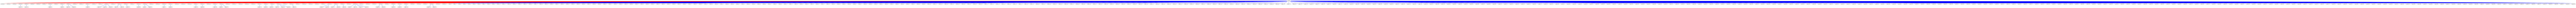

In [147]:
G = nx.Graph()
#start = '\n'.join(startNode) # for full db
start = 'Initial DB' # for names only

edges = []
provlist = []
num = 0
# for inserts in insertNodeList:
#     endInsert = '\n'.join(inserts)
#     G.add_edge(start,endInsert,penwidth=2,color='red')
#     edges.append((start,endInsert)) # for full values
    
for key,inserts in insertNameDict.items():
    endInsert = inserts
    G.add_edge(start,endInsert,penwidth=2,color='red')
    edges.append((start,endInsert)) # for names only
    
for prov in provTraces:
    startNodeSingle = []
    endNodeSingle = []
    startNode2Ignore = []
    
    for i, row in pw_rels_dfs['e_3'].iterrows():
        singleProv = [row['DATASTART'][-1],row['TRANS'][2]]
        if singleProv == prov:
            endNodeSingle.append('('+"{}".format(','.join(row['DATAEND'][1:-1])+')'))
            startNode2Ignore.append('('+"{}".format(','.join(row['DATASTART'][1:-1])+')'))
            startProv = row['DATASTART'][-1]

    provlist.append(startProv)
    if len(startProv) == 2:
        startProv = 'start'
    startNodeSingle = nodeDict[startProv] # for full data
    
    endNodeBase = [x for x in nodeDict[startProv] if x not in startNode2Ignore]
    endNodeBase.extend(endNodeSingle)
    
    #print(prov)
    prov = prov[1]
    nodeDict[prov] = endNodeBase
    nodeNameDict[prov] = 'Update '+str(num)
    
#     startNodeSingle = '\n'.join(startNodeSingle)# for full data
#     endNodeSingle = '\n'.join(endNodeBase)# for full data
    
    startNodeSingle = nodeNameDict[startProv] # names only
    endNodeSingle = nodeNameDict[prov] # names only
    G.add_edge(startNodeSingle,endNodeSingle,penwidth=2,color='blue')
    edges.append((startNodeSingle, endNodeSingle))
    num += 1

    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'

draw(G)

In [128]:
start = nodeDict['start']
startNode = '\n'.join(start)

In [129]:
startNode = nodeNameDict['start']

In [130]:
nodeKeys = list(nodeNameDict.keys())
targetNum = 10
targets = []
for x in range(targetNum):
    targets.append(random.randint(0,len(nodeDict)-1))

targetPos = [nodeNameDict[nodeKeys[x]] for x in targets]
#targetNewFormat = ['\n'.join(t) for t in targetPos]

In [131]:
def getGraphStats(G,target,start):
    allPaths = []
    #for sources in dataValuesNonStr:
    singlePath = []
    for path in nx.all_simple_paths(G,source=start,target=target):
        singlePath.append(path)
    allPaths.append(singlePath)
    APP = len(allPaths[0])
    
    allPSorted = sorted(allPaths[0])
    allPSet = set(frozenset(x) for x in allPSorted)
    DIFF = [list(x) for x in allPSet]
    DIFFNUM = len(DIFF)
    
    minPath = nx.shortest_path(G,start,target)
    smallpp = len(minPath)
    
    return [APP,DIFFNUM,smallpp]

In [132]:
stats = getGraphStats(G,targetPos[0],startNode)

In [133]:
statyBojangles = []
for x in targetPos:
    statyBojangles.append(getGraphStats(G,x,startNode))

In [134]:
statyBojangles

[[1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 3]]